# Import library

In [1]:
import os
import sys
import traci
from sumolib import checkBinary 
import pandas as pd
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# Set the variable
Logic 
1. Number of halting vehicles 
2. Propotion of vehicles and number of lane

Index phases from Traffic light logic
- North -> 0 (-E2, 66)
- South -> 2 (-E0, 71)
- West -> 4 (-E1, 45)
- East -> 6 (-E3, 50)

In [ ]:
useGui = False
logic = 2
yellowTime = 4
maxPercentProportion = 0.5
cal_halting = 0.4
maximum_green = 60
# จำนวนรถที่รองรับได้ต่อเลน
numCarExpected = 10
vphs = [2500, 3000, 3500, 4000, 4500, 5000]
num_lane = [3, 4, 2, 2]
latest_time = [66, 71, 45, 50]
edge_name = ['-E2', '-E0', '-E1', '-E3']
direction = ['N', 'S', 'W', 'E']

In [ ]:
if logic == 1:
    name = 'num_halting'
    graph = 'number of halting vehicles'
elif logic == 2:
    name = 'proportion_latest'
    graph = 'proportion from the latest duration'

# Function 

In [ ]:
def getEdgeHaltingVehicles(edge):
  return traci.edge.getLastStepHaltingNumber(edge)

def getEdgeTotalVehicles(edge):
  return traci.edge.getLastStepVehicleNumber(edge)

def getEdgeWaitingTime(edge):
  return traci.edge.getWaitingTime(edge)

def getEdgeAccumulativeWaitingTime(edge):
  # get all vehicles ID and then get accumulative waiting time for each car ID
  return sum(traci.vehicle.getAccumulatedWaitingTime(vehicle) for vehicle in traci.edge.getLastStepVehicleIDs(edge))

def getCarIdwithDir(carID_dir):
  for i in traci.edge.getLastStepVehicleIDs('-E2'):
    carID_dir['N'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E0'):
    carID_dir['S'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E1'):
    carID_dir['W'].add(i)
  for i in traci.edge.getLastStepVehicleIDs('-E3'):
    carID_dir['E'].add(i)

def checkFirstCarArrive():
  return len(traci.edge.getLastStepVehicleIDs('E2')) != 0 or len(traci.edge.getLastStepVehicleIDs('E1')) != 0 \
  or len(traci.edge.getLastStepVehicleIDs('E0')) != 0 or len(traci.edge.getLastStepVehicleIDs('E3')) != 0
 
def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

def waiting_time_direction(carID_dir, waiting_time):
  total_time_n = 0;total_time_s = 0
  total_time_w = 0;total_time_e = 0
  for carid in carID_dir['N']:
    total_time_n += waiting_time[carid]
  for carid in carID_dir['S']:
    total_time_s += waiting_time[carid]
  for carid in carID_dir['W']:
    total_time_w += waiting_time[carid]
  for carid in carID_dir['E']:
    total_time_e += waiting_time[carid]

  return total_time_n, total_time_s, total_time_w, total_time_e

def checkLasttCarDepart():
  return len(traci.edge.getLastStepVehicleIDs('-E2')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E1')) == 0 \
  and len(traci.edge.getLastStepVehicleIDs('-E0')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E3')) == 0

## Variable explain

In [ ]:
# simulation_data: save time for each logic
'''
traffic_control: save the traffic light time of each simulation
    {
        '1000': Dataframe of direction and time
    }
'''
traffic_control = {}

waiting_time_df = pd.DataFrame(columns=['Vehicles', 'North Waiting Time', 'South Waiting Time', 
                                        'East Waiting Time', 'West Waiting Time',
                                        'Total North Car', 'Total South Car', 'Total East Car', 'Total West Car',
                                        'Total Waiting Time', 'Clear Time'])

# Experiment

## Each Scenarios

In [ ]:
# train with each scenarios
for i in vphs:
  net_file = './saint_paul/junction.net.xml'
  route_path = f'./saint_paul/1.0hour/trips/{i}.rou.xml'

  if(useGui): sumoBinary = checkBinary('sumo-gui')
  else: sumoBinary = checkBinary('sumo')
  sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

  traci.start(sumoCmd)

  trafficLightId = traci.trafficlight.getIDList()[0]
  allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
  allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases
  
  switchTime = 0
  # current phase = 3 start with N
  currentPhase = 3
  yellowPhase = True
  

  waiting_time = {}
  carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}
  halting_cars = []
  all_car_in_sim = []
  proportion_lane = [1, 1, 1, 1]
  traffic_time = []
  firstTimeArrive = 0
  isArrive = False 

  while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    currentTime = traci.simulation.getTime()

    # start when the first car arrive at the junction
    if not isArrive:
      isArrive = checkFirstCarArrive()
      firstTimeArrive = currentTime
      continue

    # find the next phases to open (yellow and green)
    if currentTime >= switchTime:
      # Swicth to green phase
      if yellowPhase:
        currentPhase = (currentPhase + 1) % 4
        if logic == 1:
          totalHaltingVehicles = getEdgeHaltingVehicles(edge_name[currentPhase])
          green_time = int(min(max(15, totalHaltingVehicles / (cal_halting * num_lane[currentPhase])), maximum_green))
          switchTime += green_time

          traffic_time.append([direction[currentPhase], green_time])
          
        elif logic == 2:
          realCars = getEdgeHaltingVehicles(edge_name[currentPhase])

          if realCars == 0: green_time = 15
          else:
            expectedCars = num_lane[currentPhase] * numCarExpected
            current_proportion = realCars/expectedCars 
            
            proportion_lane[currentPhase] = current_proportion
            avg_proportion = sum(proportion_lane)/4 if sum(proportion_lane) != 0 else 1

            current_based = current_proportion - 1
            overall_based = current_proportion/avg_proportion - 1
            
            green_time = int(latest_time[currentPhase] * (1 + max(min(current_based + overall_based, maxPercentProportion), -maxPercentProportion)))
            green_time = max(green_time, 15)
            green_time = min(green_time, maximum_green)

            # print(current_based, overall_based)
          latest_time[currentPhase] = green_time
         
          switchTime += green_time
          traffic_time.append([direction[currentPhase], green_time])
        
        yellowPhase = False
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2].state)
      # Swicth to yellow phase before switch to green phase
      else:
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2 + 1].state)
        switchTime += yellowTime
        yellowPhase = True

    if checkLasttCarDepart():
      total_clear_time = currentTime
      break
    
    vehicles = traci.vehicle.getIDList()
    getCarIdwithDir(carID_dir)
    all_car_in_sim.append(len(vehicles))
    halting_cars.append(sum(getEdgeHaltingVehicles(edge) for edge in edge_name))
    
    for vehicle in vehicles:
      vehicle_waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle)
      if(vehicle not in waiting_time):
        waiting_time[vehicle] = vehicle_waiting_time
      else:
        waiting_time[vehicle] = max(vehicle_waiting_time, waiting_time[vehicle])

 
  wt_n, wt_s, wt_w, wt_e = waiting_time_direction(carID_dir=carID_dir, waiting_time=waiting_time)
  total_waiting_time = wt_n + wt_s + wt_w + wt_e
  carID_dir
  waiting_time_df.loc[len(waiting_time_df.index)] = [i, wt_n, wt_s, wt_e, wt_w, 
                                                     len(carID_dir['N']),len(carID_dir['S']),len(carID_dir['E']),len(carID_dir['W']),
                                                     total_waiting_time, total_clear_time-firstTimeArrive]  
  
  traffic_control[i] = pd.DataFrame(traffic_time, columns=['Direction', 'Time']) 

  print('\n', i, total_waiting_time, total_clear_time)
    
  traci.close()

waiting_time_df['Vehicles'] = waiting_time_df['Vehicles'].astype('int')

## Each Type mehod

In [ ]:
# train with types
adaptive_df = pd.DataFrame(columns=['Types', 'North Waiting Time', 'South Waiting Time', 
                                    'East Waiting Time', 'West Waiting Time',
                                    'Total North Car', 'Total South Car', 'Total East Car', 'Total West Car',
                                    'Total Waiting Time', 'Clear Time'])
for i in range(6):
  net_file = './saint_paul/junction.net.xml'
  route_path = './saint_paul/1.0hour/trips/situation/rain_4500.rou.xml'

  if(useGui): sumoBinary = checkBinary('sumo-gui')
  else: sumoBinary = checkBinary('sumo')
  sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

  traci.start(sumoCmd)

  trafficLightId = traci.trafficlight.getIDList()[0]
  allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
  allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases
  
  switchTime = 0
  currentPhase = 3
  yellowPhase = True
  
  waiting_time = {}
  carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}
  halting_cars = []
  proportion_lane = [1, 1, 1, 1]
  traffic_time = []
  firstTimeArrive = 0
  isArrive = False 

  if i==0:
    adaptive_type = 'Fixed Time'
  elif i==1: 
    adaptive_type, logic, maximum_green = 'Halting Number with max 60', 1, 60
  elif i==2:
    adaptive_type, logic, maximum_green = 'Halting Number with max 120', 1, 120
  elif i==3:
    adaptive_type, logic, maxPercentProportion, maximum_green, numCarExpected = 'Proportion with 0.5, 5 vehicles/lane', 2, 0.5, 60, 5
  elif i==4:
    adaptive_type, logic, maxPercentProportion, maximum_green, numCarExpected = 'Proportion with 0.5, 10 vehicles/lane', 2, 0.5, 60, 10
  elif i==5:
    adaptive_type, logic, maxPercentProportion, maximum_green, numCarExpected = 'Proportion with 0.2, 5 vehicles/lane', 2, 0.2, 60, 5

  while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    currentTime = traci.simulation.getTime()

    # start when the first car arrive at the junction
    if not isArrive:
      isArrive = checkFirstCarArrive()
      firstTimeArrive = currentTime
      continue

    if i!=0:
      # find the next phases to open (yellow and green)
      if currentTime >= switchTime:
        # Swicth to green phase
        if yellowPhase:
          currentPhase = (currentPhase + 1) % 4
          if logic == 1:
            totalHaltingVehicles = getEdgeHaltingVehicles(edge_name[currentPhase])
            green_time = int(min(max(15, totalHaltingVehicles / (cal_halting * num_lane[currentPhase])), maximum_green))
            switchTime += green_time
            traffic_time.append([direction[currentPhase], green_time])
            
          elif logic == 2:
            realCars = getEdgeHaltingVehicles(edge_name[currentPhase])

            if realCars == 0: green_time = 15
            else:
              expectedCars = num_lane[currentPhase] * numCarExpected
              current_proportion = realCars/expectedCars 
              
              proportion_lane[currentPhase] = current_proportion
              avg_proportion = sum(proportion_lane)/4 if sum(proportion_lane) != 0 else 1

              current_based = current_proportion - 1
              overall_based = current_proportion/avg_proportion - 1
              
              green_time = int(latest_time[currentPhase] * (1 + max(min(current_based + overall_based, maxPercentProportion), -maxPercentProportion)))
              green_time = max(green_time, 15)
              green_time = min(green_time, maximum_green)

              # print(current_based, overall_based)
            latest_time[currentPhase] = green_time
            switchTime += green_time
            traffic_time.append([direction[currentPhase], green_time])
          
          yellowPhase = False
          traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2].state)
        # Swicth to yellow phase before switch to green phase
        else:
          traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2 + 1].state)
          switchTime += yellowTime
          yellowPhase = True

    if checkLasttCarDepart():
      total_clear_time = currentTime
      break
    
    vehicles = traci.vehicle.getIDList()
    getCarIdwithDir(carID_dir)
    halting_cars.append(sum(getEdgeHaltingVehicles(edge) for edge in edge_name))
    
    for vehicle in vehicles:
      vehicle_waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle)
      if(vehicle not in waiting_time):
        waiting_time[vehicle] = vehicle_waiting_time
      else:
        waiting_time[vehicle] = max(vehicle_waiting_time, waiting_time[vehicle])

 
  wt_n, wt_s, wt_w, wt_e = waiting_time_direction(carID_dir=carID_dir, waiting_time=waiting_time)
  total_waiting_time = wt_n + wt_s + wt_w + wt_e
  adaptive_df.loc[len(adaptive_df.index)] = [adaptive_type, wt_n, wt_s, wt_e, wt_w, 
                                            len(carID_dir['N']),len(carID_dir['S']),len(carID_dir['E']),len(carID_dir['W']),
                                            total_waiting_time, total_clear_time-firstTimeArrive]  
  
  traffic_control[i] = pd.DataFrame(traffic_time, columns=['Direction', 'Time']) 
  print('\n', i, total_waiting_time, total_clear_time-firstTimeArrive)
    
  traci.close()

In [ ]:
adaptive_df

# Save Results

In [ ]:
if logic == 1:
    waiting_time_df.to_csv(f'./saint_paul/1.0hour/limit_speed_120km/{name}_{maximum_green}.csv', index=False)
else:
    waiting_time_df.to_csv(f'./saint_paul/1.0hour/limit_speed_120km/{name}_{maxPercentProportion}_{numCarExpected}.csv', index=False)

In [ ]:
adaptive_df.to_csv(f'./saint_paul/1.0hour/situation/rain_4500.csv', index=False)
# waiting_time_df.to_csv(f'./saint_paul/1.0hour/limit_speed_120km/fixed_time.csv', index=False)


# Plot graph

### Plot Average Waiting Time per Car

### Each Scenraios

In [ ]:
total_car = waiting_time_df['Total North Car'] + waiting_time_df['Total South Car']  + waiting_time_df['Total East Car']+ waiting_time_df['Total West Car']
waiting_time_df['Average North Waiting Time'] = waiting_time_df['North Waiting Time']/waiting_time_df['Total North Car']/60
waiting_time_df['Average South Waiting Time'] = waiting_time_df['South Waiting Time']/waiting_time_df['Total South Car']/60
waiting_time_df['Average East Waiting Time'] = waiting_time_df['East Waiting Time']/waiting_time_df['Total East Car']/60
waiting_time_df['Average West Waiting Time'] = waiting_time_df['West Waiting Time']/waiting_time_df['Total West Car']/60
waiting_time_df['Average Total Waiting Time'] = waiting_time_df['Total Waiting Time']/total_car/60
waiting_time_df

In [ ]:
wait_df = waiting_time_df[['Vehicles', 'Average North Waiting Time', 'Average South Waiting Time', 'Average East Waiting Time', 'Average West Waiting Time', 'Average Total Waiting Time']]
ax = wait_df.plot(x='Vehicles', 
            kind='bar', 
            stacked=False, 
            title=f'Average Waiting Time for Each Car',
            width=0.6,
            # figsize=(12,5)
)
ax.set_xticklabels(wait_df['Vehicles'].astype(int), rotation=0)
plt.ylabel('minutes')

In [ ]:
clear_time = waiting_time_df[['Vehicles', 'Clear Time']]
clear_time['Clear Time'] = clear_time['Clear Time']/60 - 60
clear_time.plot(x='Vehicles', y='Clear Time')

### Each method with the same situation

In [55]:
adaptive_df = pd.read_csv('./saint_paul/1.0hour/situation/rain_4500.csv')
total_car = adaptive_df['Total North Car'] + adaptive_df['Total South Car']  + adaptive_df['Total East Car']+ adaptive_df['Total West Car']
adaptive_df['Average North Waiting Time'] = adaptive_df['North Waiting Time']/adaptive_df['Total North Car']/60
adaptive_df['Average South Waiting Time'] = adaptive_df['South Waiting Time']/adaptive_df['Total South Car']/60
adaptive_df['Average East Waiting Time'] = adaptive_df['East Waiting Time']/adaptive_df['Total East Car']/60
adaptive_df['Average West Waiting Time'] = adaptive_df['West Waiting Time']/adaptive_df['Total West Car']/60
adaptive_df['Average Total Waiting Time'] = adaptive_df['Total Waiting Time']/total_car/60
adaptive_df

FileNotFoundError: [Errno 2] No such file or directory: './saint_paul/1.0hour/situation/raining_4500.csv'

In [51]:
improve_waiting = adaptive_df[['Types', 'Average North Waiting Time', 'Average South Waiting Time', 
                            'Average East Waiting Time', 'Average West Waiting Time', 'Average Total Waiting Time']]

improve_waiting_t = improve_waiting.T
improve_waiting_t.columns = improve_waiting_t.iloc[0]
improve_waiting_t.drop(index='Types', inplace=True)

columns = improve_waiting_t.columns[1:]
for col in columns:
    improvement_percentage = ((improve_waiting_t['Fixed Time'] - improve_waiting_t[col]) / improve_waiting_t['Fixed Time']) * 100
    improve_waiting_t[f'% Improvement ({col})'] = improvement_percentage
    print(f'Mean {col}', improve_waiting_t[f'% Improvement ({col})'].mean())
improve_waiting_t

Mean Halting Number with max 60 57.54631801606346
Mean Halting Number with max 120 57.54631801606346
Mean Proportion with 0.5, 5 vehicles/lane 44.19868597626985
Mean Proportion with 0.5, 10 vehicles/lane 7.596577885725816
Mean Proportion with 0.2, 5 vehicles/lane 44.230386300010515


Types,Fixed Time,Halting Number with max 60,Halting Number with max 120,"Proportion with 0.5, 5 vehicles/lane","Proportion with 0.5, 10 vehicles/lane","Proportion with 0.2, 5 vehicles/lane",% Improvement (Halting Number with max 60),% Improvement (Halting Number with max 120),"% Improvement (Proportion with 0.5, 5 vehicles/lane)","% Improvement (Proportion with 0.5, 10 vehicles/lane)","% Improvement (Proportion with 0.2, 5 vehicles/lane)"
Average North Waiting Time,4.602072,0.849464,0.849464,0.691288,0.650273,1.402304,81.541698,81.541698,84.978774,85.869997,69.528846
Average South Waiting Time,7.512955,1.140455,1.140455,1.972076,1.492652,1.358008,84.820159,84.820159,73.750996,80.132297,81.924454
Average East Waiting Time,1.239,0.930889,0.930889,1.578333,2.707444,1.397389,24.867725,24.867725,-27.387678,-118.518519,-12.783607
Average West Waiting Time,1.421524,1.208857,1.208857,1.206,2.631667,1.318905,14.960472,14.960472,15.161463,-85.129975,7.218947
Average Total Waiting Time,5.553801,1.025146,1.025146,1.416782,1.353512,1.373828,81.541536,81.541536,74.489876,75.629088,75.263292


Text(0, 0.5, 'minutes')

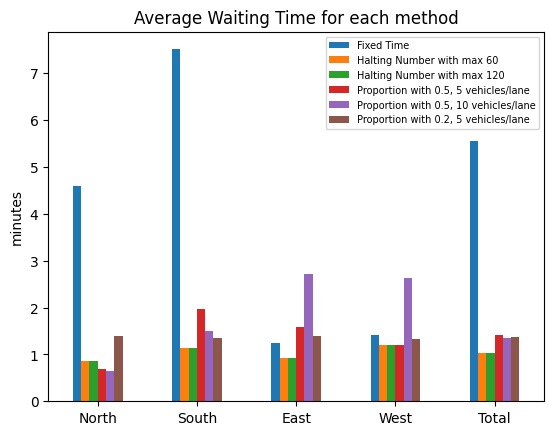

In [52]:
wait_df = adaptive_df[['Types', 'Average North Waiting Time', 'Average South Waiting Time', 'Average East Waiting Time', 'Average West Waiting Time', 'Average Total Waiting Time']]
wait_df = wait_df.T
wait_df.columns = wait_df.iloc[0]
wait_df.drop(wait_df.index[0], inplace=True)
ax = wait_df.plot(kind='bar', 
            stacked=False, 
            title=f'Average Waiting Time for each method',
            )
ax.legend(fontsize=7)
ax.set_xticklabels(['North', 'South', 'East', 'West', 'Total'], rotation=0)
plt.ylabel('minutes')

/var/folders/z3/jn6w240x59v_4tvt0q8pdph80000gn/T/ipykernel_25855/3278069088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_time['Clear Time'] = clear_time['Clear Time']/60 - 60


Text(0, 0.5, 'minutes')

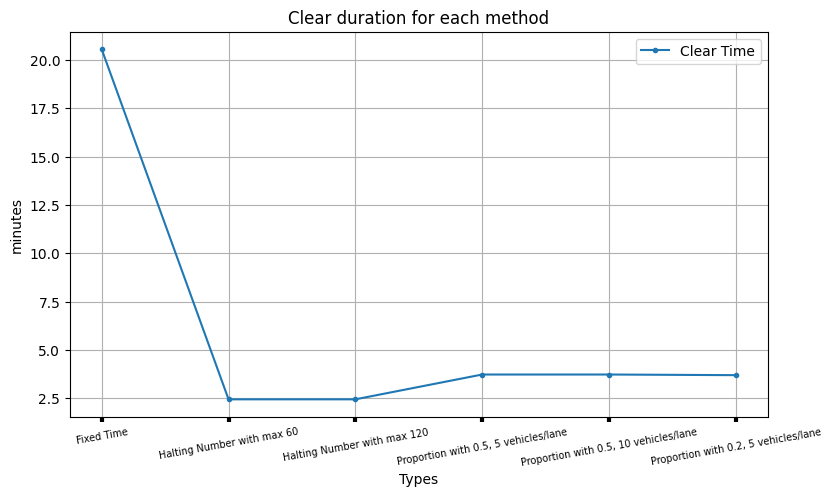

In [53]:
clear_time = adaptive_df[['Types', 'Clear Time']]
clear_time['Clear Time'] = clear_time['Clear Time']/60 - 60
ax = clear_time.plot(x='Types', y='Clear Time', 
                     grid=True, 
                     kind='line', 
                     style='.-',
                     title='Clear duration for each method', 
                     figsize=(9, 5))

ax.tick_params(axis='x',width='3', labelsize = 7, rotation=10)
# ax.set_xticklabels(clear_time['Types'])
ax.set_ylabel('minutes')

In [54]:
clear_time_t = clear_time.T
clear_time_t.columns = clear_time_t.iloc[0]
clear_time_t.drop(index='Types', inplace=True)

columns = clear_time_t.columns[1:]
for col in columns:
    improvement_percentage = ((clear_time_t['Fixed Time'] - clear_time_t[col]) / clear_time_t['Fixed Time']) * 100
    clear_time_t[f'% Improvement ({col})'] = improvement_percentage
    print(f'Mean {col}', clear_time_t[f'% Improvement ({col})'].mean())
clear_time_t

Mean Halting Number with max 60 88.07785888077856
Mean Halting Number with max 120 88.07785888077856
Mean Proportion with 0.5, 5 vehicles/lane 81.83292781832927
Mean Proportion with 0.5, 10 vehicles/lane 81.83292781832927
Mean Proportion with 0.2, 5 vehicles/lane 81.99513381995132


Types,Fixed Time,Halting Number with max 60,Halting Number with max 120,"Proportion with 0.5, 5 vehicles/lane","Proportion with 0.5, 10 vehicles/lane","Proportion with 0.2, 5 vehicles/lane",% Improvement (Halting Number with max 60),% Improvement (Halting Number with max 120),"% Improvement (Proportion with 0.5, 5 vehicles/lane)","% Improvement (Proportion with 0.5, 10 vehicles/lane)","% Improvement (Proportion with 0.2, 5 vehicles/lane)"
Clear Time,20.55,2.45,2.45,3.733333,3.733333,3.7,88.077859,88.077859,81.832928,81.832928,81.995134


### Green Time

In [ ]:
import matplotlib.pyplot as plt

num = 2

time = traffic_control[num]['Time']
direction = traffic_control[num]['Direction']

num_phase = int(len(direction) / 4)
last_phase = len(direction) % 4

direction_phase = list(direction[:4])

traffic_phase = {}
for d in range(len(direction_phase)):
    traffic_phase[direction_phase[d]] = list(time[d:num_phase*4:4])

df = pd.DataFrame(traffic_phase)
df['Cycle'] = df.index + 1
df = df[['Cycle'] + list(df.columns[:-1].values)]

ax = df.plot(x='Cycle', 
        kind='bar', 
        stacked=False, 
        title=f'Greenlight duration for Morning situtaion by Adaptive traffic control (Proportion 10)',
        width=0.6,
        figsize=(12,5)
        ) 
ax.set_xticklabels(df['Cycle'], rotation=0)
ax.plot()

In [ ]:
df['Total'] = df['N'] + df['S'] + df['W'] + df['E']
df

In [ ]:
sum(df['Total'])/df.shape[0]

# Plot Graph

In [2]:
fix_time_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/fixed_time.csv')
halting_60_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/num_halting_60.csv')
halting_90_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/num_halting_90.csv')
halting_120_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/num_halting_120.csv')
pp_latest_2_5_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/proportion_latest_0.2_5.csv')
pp_latest_2_10_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/proportion_latest_0.2_10.csv')
pp_latest_5_5_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/proportion_latest_0.5_5.csv')
pp_latest_5_10_df = pd.read_csv('./saint_paul/1.0hour/limit_speed_120km/proportion_latest_0.5_10.csv')

In [3]:
list_df = [fix_time_df, halting_60_df, halting_90_df, halting_120_df, pp_latest_2_10_df, pp_latest_5_5_df, pp_latest_5_10_df]

for df in list_df:
    total_car = df['Total North Car'] + df['Total South Car']  + df['Total East Car']+ df['Total West Car']
    df['Total Car'] = total_car

In [4]:
halting_60_df.head()

,Vehicles,North Waiting Time,South Waiting Time,East Waiting Time,West Waiting Time,Total North Car,Total South Car,Total East Car,Total West Car,Total Waiting Time,Clear Time,Total Car
0,2500,16547.0,27314.0,7969.0,6826.0,742.0,1050.0,375.0,336.0,58656.0,3625.0,2503.0
1,3000,24979.0,41936.0,9222.0,8411.0,889.0,1256.0,450.0,405.0,84548.0,3632.0,3000.0
2,3500,36063.0,51254.0,13492.0,11183.0,1037.0,1466.0,528.0,471.0,111992.0,3664.0,3502.0
3,4000,50858.0,72738.0,31137.0,25344.0,1186.0,1678.0,600.0,540.0,180077.0,3717.0,4004.0
4,4500,106847.0,195187.0,69539.0,58760.0,1335.0,1889.0,675.0,606.0,430333.0,3837.0,4505.0


### Plot waiting time with given direction

In [29]:
direction_name = 'Total Waiting Time'
car_total = 'Total Car'
waiting_time_df = pd.DataFrame({'Vehicles': halting_60_df[car_total], 
                                'Fix-time': fix_time_df[direction_name]/fix_time_df[car_total]/60,
                                'Halting with max 60': halting_60_df[direction_name]/halting_60_df[car_total]/60,
                                'Halting with max 90': halting_90_df[direction_name]/halting_90_df[car_total]/60,
                                'Halting with max 120': halting_120_df[direction_name]/halting_120_df[car_total]/60,
                                'Proportion with 0.2, 10 veh/lane': pp_latest_2_10_df[direction_name]/pp_latest_2_10_df[car_total]/60,
                                'Proportion with 0.5, 5 veh/lane': pp_latest_5_5_df[direction_name]/pp_latest_5_5_df[car_total]/60,
                                'Proportion with 0.5, 10 veh/lane': pp_latest_5_10_df[direction_name]/pp_latest_5_10_df[car_total]/60,
})
waiting_time_df

,Vehicles,Fix-time,Halting with max 60,Halting with max 90,Halting with max 120,"Proportion with 0.2, 10 veh/lane","Proportion with 0.5, 5 veh/lane","Proportion with 0.5, 10 veh/lane"
0,2503.0,1.152370,0.390571,0.390571,0.390571,0.428446,1.201978,0.390818
1,3000.0,1.196161,0.469711,0.469711,0.469711,0.457111,1.235900,0.465633
2,3502.0,1.237160,0.532991,0.532991,0.532991,0.556753,1.326823,0.558876
3,4004.0,1.348477,0.749571,0.749571,0.749571,1.095650,1.884928,1.253925
4,4505.0,2.035279,1.592057,1.468864,1.468864,3.331450,3.503718,2.715043
5,5004.0,3.936511,4.189668,3.599011,3.378750,4.956551,4.923331,4.814558


In [30]:
df = waiting_time_df.copy()
columns = df.columns[1:]
for col in columns:
    improvement_percentage = ((df['Fix-time'] - df[col]) / df['Fix-time']) * 100
    df[f'Improvement ({col})'] = improvement_percentage
    print(f'Mean {col}', df[f'Improvement ({col})'].mean())
df

Mean Fix-time 0.0
Mean Halting with max 60 40.58609437660481
Mean Halting with max 90 44.09567124869531
Mean Halting with max 120 45.0282249321209
Mean Proportion with 0.2, 10 veh/lane 18.125777041849446
Mean Proportion with 0.5, 5 veh/lane -25.31235844909283
Mean Proportion with 0.5, 10 veh/lane 22.215302585217376


,Vehicles,Fix-time,Halting with max 60,Halting with max 90,Halting with max 120,"Proportion with 0.2, 10 veh/lane","Proportion with 0.5, 5 veh/lane","Proportion with 0.5, 10 veh/lane",Improvement (Fix-time),Improvement (Halting with max 60),Improvement (Halting with max 90),Improvement (Halting with max 120),"Improvement (Proportion with 0.2, 10 veh/lane)","Improvement (Proportion with 0.5, 5 veh/lane)","Improvement (Proportion with 0.5, 10 veh/lane)"
0,2503.0,1.152370,0.390571,0.390571,0.390571,0.428446,1.201978,0.390818,0.0,66.107140,66.107140,66.107140,62.820476,-4.304791,66.085761
1,3000.0,1.196161,0.469711,0.469711,0.469711,0.457111,1.235900,0.465633,0.0,60.731785,60.731785,60.731785,61.785155,-3.322202,61.072691
2,3502.0,1.237160,0.532991,0.532991,0.532991,0.556753,1.326823,0.558876,0.0,56.918200,56.918200,56.918200,54.997461,-7.247492,54.825891
3,4004.0,1.348477,0.749571,0.749571,0.749571,1.095650,1.884928,1.253925,0.0,44.413473,44.413473,44.413473,18.749035,-39.782009,7.011711
4,4505.0,2.035279,1.592057,1.468864,1.468864,3.331450,3.503718,2.715043,0.0,21.776979,27.829846,27.829846,-63.685161,-72.149250,-33.399014
5,5004.0,3.936511,4.189668,3.599011,3.378750,4.956551,4.923331,4.814558,0.0,-6.431012,8.573582,14.168905,-25.912304,-25.068407,-22.305224


/var/folders/z3/jn6w240x59v_4tvt0q8pdph80000gn/T/ipykernel_25855/3326715287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improve_percent['Vehicles'] = df['Vehicles']


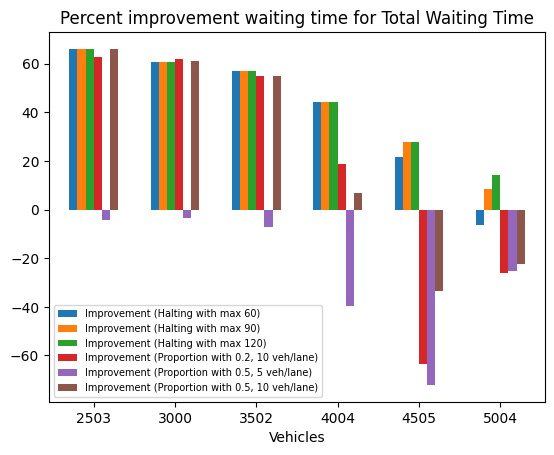

In [31]:
improve_percent = df[df.columns[9:]]
improve_percent['Vehicles'] = df['Vehicles']
# plot bar graph
ax = improve_percent.plot(x='Vehicles', 
        kind='bar', 
        stacked=False, 
        # grid=True,          
        title=f'Percent improvement waiting time for {direction_name}',
        width=0.6
) 
ax.legend(fontsize=7)
ax.set_xticklabels(waiting_time_df['Vehicles'].astype(int), rotation=0)
ax.tick_params(axis = 'x' , labelsize = 10 )

Text(0, 0.5, 'Minutes')

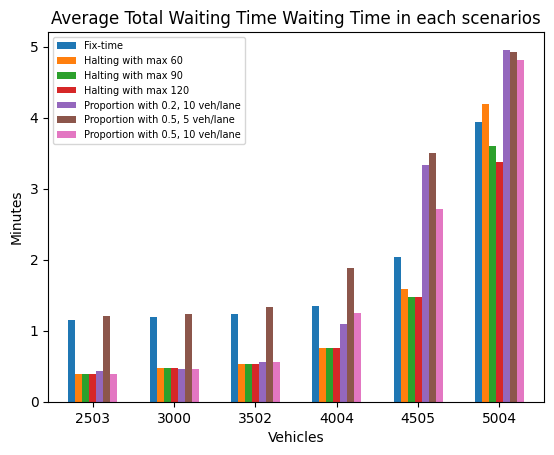

In [32]:
# plot bar graph
ax = waiting_time_df.plot(x='Vehicles', 
        kind='bar', 
        stacked=False, 
        # grid=True,          
        title=f'Average {direction_name} Waiting Time in each scenarios',
        width=0.6
) 
ax.legend(fontsize=7)
ax.set_xticklabels(waiting_time_df['Vehicles'].astype(int), rotation=0)
ax.tick_params(axis = 'x' , labelsize = 10 )
plt.ylabel('Minutes')

Text(0, 0.5, 'Minutes')

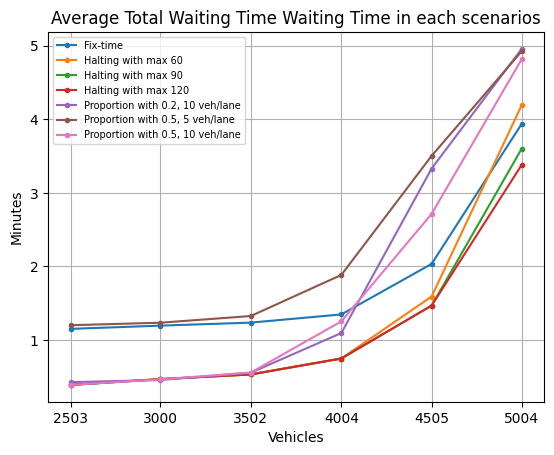

In [33]:
ax = waiting_time_df.plot(x='Vehicles', 
        kind='line', 
        stacked=False, 
        grid=True,  
        style='.-',
        title=f'Average {direction_name} Waiting Time in each scenarios',
) 
ax.legend(fontsize=7)
ax.set_xticks(waiting_time_df['Vehicles'].astype(int))
ax.tick_params(axis = 'x' , labelsize = 10 )
plt.ylabel('Minutes')

In [34]:
clear_time = pd.DataFrame({'Vehicles': halting_60_df['Total Car'], 
                            'Fix-time': fix_time_df['Clear Time']/60-60,
                            'Halting with max 60': halting_60_df['Clear Time']/60-60,
                            'Halting with max 90': halting_90_df['Clear Time']/60-60,
                            'Halting with max 120': halting_120_df['Clear Time']/60-60,
                            'Proportion with 0.2, 10 veh/lane': pp_latest_2_10_df ['Clear Time']/60-60,
                            'Proportion with 0.5, 5 veh/lane': pp_latest_5_5_df ['Clear Time']/60-60,
                            'Proportion with 0.5, 10 veh/lane': pp_latest_5_10_df ['Clear Time']/60-60,
})
clear_time

,Vehicles,Fix-time,Halting with max 60,Halting with max 90,Halting with max 120,"Proportion with 0.2, 10 veh/lane","Proportion with 0.5, 5 veh/lane","Proportion with 0.5, 10 veh/lane"
0,2503.0,2.183333,0.416667,0.416667,0.416667,0.883333,2.700000,0.383333
1,3000.0,2.200000,0.533333,0.533333,0.533333,0.866667,2.450000,0.733333
2,3502.0,2.266667,1.066667,1.066667,1.066667,1.550000,2.883333,1.183333
3,4004.0,2.266667,1.950000,1.950000,1.950000,3.533333,3.683333,2.416667
4,4505.0,9.850000,3.950000,3.216667,3.216667,7.433333,8.666667,6.733333
5,5004.0,14.416667,10.733333,8.450000,7.566667,12.783333,12.233333,12.516667


In [35]:
df = clear_time.copy()
columns = df.columns[1:]
for col in columns:
    improvement_percentage = ((df['Fix-time'] - df[col]) / df['Fix-time']) * 100
    df[f'% Improvement ({col})'] = improvement_percentage
    print(f'Mean {col}', df[f'% Improvement ({col})'].mean())
df

Mean Fix-time 0.0
Mean Halting with max 60 51.505496850524395
Mean Halting with max 90 55.386023308733435
Mean Halting with max 120 56.407217913743075
Mean Proportion with 0.2, 10 veh/lane 21.95791769942558
Mean Proportion with 0.5, 5 veh/lane -16.2625993007406
Mean Proportion with 0.5, 10 veh/lane 39.18439367565951


,Vehicles,Fix-time,Halting with max 60,Halting with max 90,Halting with max 120,"Proportion with 0.2, 10 veh/lane","Proportion with 0.5, 5 veh/lane","Proportion with 0.5, 10 veh/lane",% Improvement (Fix-time),% Improvement (Halting with max 60),% Improvement (Halting with max 90),% Improvement (Halting with max 120),"% Improvement (Proportion with 0.2, 10 veh/lane)","% Improvement (Proportion with 0.5, 5 veh/lane)","% Improvement (Proportion with 0.5, 10 veh/lane)"
0,2503.0,2.183333,0.416667,0.416667,0.416667,0.883333,2.700000,0.383333,0.0,80.916031,80.916031,80.916031,59.541985,-23.664122,82.442748
1,3000.0,2.200000,0.533333,0.533333,0.533333,0.866667,2.450000,0.733333,0.0,75.757576,75.757576,75.757576,60.606061,-11.363636,66.666667
2,3502.0,2.266667,1.066667,1.066667,1.066667,1.550000,2.883333,1.183333,0.0,52.941176,52.941176,52.941176,31.617647,-27.205882,47.794118
3,4004.0,2.266667,1.950000,1.950000,1.950000,3.533333,3.683333,2.416667,0.0,13.970588,13.970588,13.970588,-55.882353,-62.500000,-6.617647
4,4505.0,9.850000,3.950000,3.216667,3.216667,7.433333,8.666667,6.733333,0.0,59.898477,67.343486,67.343486,24.534687,12.013536,31.641286
5,5004.0,14.416667,10.733333,8.450000,7.566667,12.783333,12.233333,12.516667,0.0,25.549133,41.387283,47.514451,11.329480,15.144509,13.179191


Text(0, 0.5, 'Minutes')

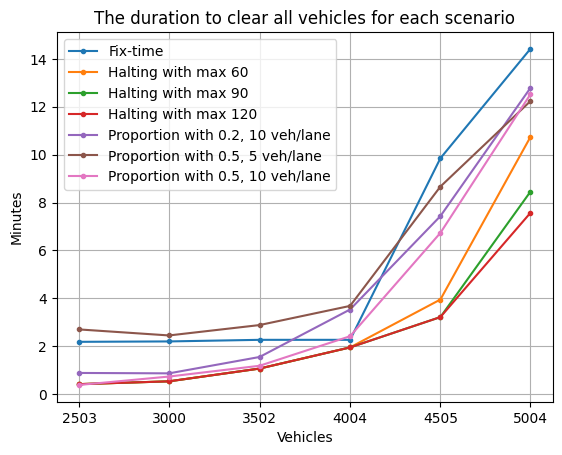

In [36]:
ax = clear_time.plot(x='Vehicles', 
        kind='line', 
        stacked=False, 
        grid=True,  
        style='.-',
        title=f'The duration to clear all vehicles for each scenario',
) 

ax.set_xticks(clear_time['Vehicles'].astype(int))
# ax.tick_params(axis = 'x' , labelsize = 10 )
plt.ylabel('Minutes')

In [37]:
clear_time

,Vehicles,Fix-time,Halting with max 60,Halting with max 90,Halting with max 120,"Proportion with 0.2, 10 veh/lane","Proportion with 0.5, 5 veh/lane","Proportion with 0.5, 10 veh/lane"
0,2503.0,2.183333,0.416667,0.416667,0.416667,0.883333,2.700000,0.383333
1,3000.0,2.200000,0.533333,0.533333,0.533333,0.866667,2.450000,0.733333
2,3502.0,2.266667,1.066667,1.066667,1.066667,1.550000,2.883333,1.183333
3,4004.0,2.266667,1.950000,1.950000,1.950000,3.533333,3.683333,2.416667
4,4505.0,9.850000,3.950000,3.216667,3.216667,7.433333,8.666667,6.733333
5,5004.0,14.416667,10.733333,8.450000,7.566667,12.783333,12.233333,12.516667


In [ ]:
fix_time_df_plot = pp_latest_2_10_df[['Total Car', 'North Waiting Time', 'South Waiting Time', 'East Waiting Time', 'West Waiting Time', 'Total Waiting Time']]
fix_time_df_plot['North Waiting Time'] = fix_time_df_plot['North Waiting Time']/fix_time_df['Total North Car']/60
fix_time_df_plot['South Waiting Time'] = fix_time_df_plot['South Waiting Time']/fix_time_df['Total South Car']/60
fix_time_df_plot['East Waiting Time'] = fix_time_df_plot['East Waiting Time']/fix_time_df['Total East Car']/60
fix_time_df_plot['West Waiting Time'] = fix_time_df_plot['West Waiting Time']/fix_time_df['Total West Car']/60
fix_time_df_plot['Total Waiting Time'] = fix_time_df_plot['Total Waiting Time']/fix_time_df['Total Car']/60
ax = fix_time_df_plot.plot(x='Total Car', 
            kind='bar', 
            stacked=False, 
            title=f'Average Waiting Time by proportion 0.2, 10 veh',
            width=0.6,
            # figsize=(12,5)
)
ax.set_xticklabels(fix_time_df_plot['Total Car'].astype(int), rotation=0)
plt.ylabel('minutes')

In [ ]:
fix_time_df_plot

In [ ]:
fix_time_df_clear = pp_latest_2_5_df[['Total Car', 'Clear Time']] 
fix_time_df_clear['Clear Time'] = fix_time_df_clear['Clear Time']/60-60
ax = fix_time_df_clear.plot(x='Total Car', 
            kind='line',
            stacked=False,
            grid=True,  
            style='.-',
            title=f'The duration to clear all vehicles for each scenario',
            # figsize=(12,5)
)
# ax.set_xticklabels(fix_time_df_clear['Total Car'].astype(int))
plt.ylabel('minutes')
plt.show()

In [ ]:
fix_time_df_clear